Model of shoaling behavior based on the Boids model by Craig Reynolds in 1986,
using the basic code provided in the Flocker example of the Mesa framework for
agent-based modelling in Python. This model is based on 3 parameters that each
agent follows:
    1. Attraction to (coherence with) other agents,
    2. Avoidance of other agents,
    3. Alignment with other agents.
The direction in which the agents swim is determined by the "speed" parameter
and can be either positive (towards the upper, left corner) or negative
(towards the lower, right corner). Therefore, the overall direction of the
group is not random, but their starting position and heading is.

The model is based on a bounded, 3D area. Later additions
will include obstacles, environmental gradients, and agents with goal-, food-, or safety-seeking behaviour.

This Jupyter notebook version is useful for changing the parameters of the model and seeingthe effect on cohesion without having to re-write the model each time. Parameters explored here include vision and number of individuals and the effect these parameters have on
cohesion. 

In [8]:
# Packages and libraries
import numpy as np
import math
import random
from scipy import ndimage
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import ContinuousSpace
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.ModularVisualization import VisualizationElement
from mesa.visualization.modules import ChartModule

In [9]:
def polar(model):
    """
    Computes standard deviation from the mean heading of the group. As the
    value approaches 0, polarization increases.

    Heading is a unit vector, meaning the magnitude is 1 and the direction is
    given as x,y coordinates. In order to find the mean & stdev, the x,y
    (Cartesian) coordinates are converted to angle degrees in radians by
    finding the arc tangent of y/x. The function used to do this is arctan2
    from the math package, which pays attention to the sign of the input to
    make sure that the correct quadrant for the angle is determined. Then, the
    standard deviation is calculated from these values.
    """
    heading_x = [agent.heading[0] for agent in model.schedule.agents]
    heading_y = [agent.heading[1] for agent in model.schedule.agents]
    angle = []
    for (y, x) in zip(heading_y, heading_x):
        a = math.atan2(y, x)
        angle.append(a)
    stdev_h = np.std(angle, axis=None)

    return stdev_h

In [10]:
# Defines the Agent class for the "fish" in the model
class Fish(Agent):
    """
    A Boid-style flocker agent. Boids have a vision that defines the radius in
    which they look for their neighbors to flock with. Their heading (a unit
    vector) and their interactions with their neighbors - cohering and avoiding -
    define their movement. Avoidance is their desired minimum distance from
    any other Boid.
    """
    def __init__(self, unique_id, model, pos, speed=3, velocity=None,
                 vision=5, avoidance=1):
        """
        Create a new Boid (bird, fish) agent. Args:
            unique_id: unique agent identifier.
            pos: starting position
            speed: distance to move per step. Since it's positive, boids move
                in a positive direction.
            velocity: randomly generated. Velocity can then be normalized to
                create the heading - the scalar version w/ no magnitude.
            vision: Radius to look around for nearby Boids.
            avoidance: Minimum distance to maintain from other Boids.
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.speed = speed
        if velocity is not None:
            self.velocity = velocity
            self.heading = self.velocity / np.linalg.norm(self.velocity)
        else:
            self.velocity = np.random.uniform(2) - 0.5
            self.heading /= np.linalg.norm(self.velocity)
        self.vision = vision
        self.avoidance = avoidance

    def cohere(self, neighbors):
        """
        Return the vector toward the center of mass of the local neighbors.
        """
        coh_vector = np.array([0.0, 0.0])
        their_pos = [neighbor.pos for neighbor in neighbors]
        their_pos = np.asarray(their_pos)
        center = ndimage.measurements.center_of_mass(their_pos)
        coh_vector += np.subtract(center, self.pos)  # both are tuples
        if np.linalg.norm(coh_vector) > 0:  # when there is already a magnitude
            return coh_vector / np.linalg.norm(coh_vector)
        else:
            return coh_vector

    def avoid(self, neighbors):
        """
        Return a vector away rom any neighbors closer than avoidance distance.
        """
        my_pos = np.array(self.pos)
        avoid_vector = np.array([0, 0])
        for neighbor in neighbors:
            their_pos = np.array(neighbor.pos)
            dist = np.linalg.norm(my_pos - their_pos)
            if dist <= self.avoidance:
                avoid_vector -= np.int64(their_pos - my_pos)  # tuples
        if np.linalg.norm(avoid_vector) > 0:
            return avoid_vector / np.linalg.norm(avoid_vector)
        else:
            return avoid_vector

    def match_velocity(self, neighbors):
        """
        Have Boids match the velocity of neighbors.
        """
        mean_velocity = np.array([0.0, 0.0])
        for neighbor in neighbors:
            mean_velocity += neighbor.velocity / len(neighbors)
        return mean_velocity
        # Not checking for an normalizing this function because we want to
        # retain the magnitude.

    def step(self):
        """ 
        Get the Boid's neighbors, compute the new vector, normalize that
        vector, and move accordingly.
        """
        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        if len(neighbors) > 0:
            cohere_vector = self.cohere(neighbors)
            avoid_vector = self.avoid(neighbors)
            velocity = self.match_velocity(neighbors)
            match_heading = velocity / np.linalg.norm(velocity)
            self.heading += (cohere_vector +
                             avoid_vector +
                             match_heading)
        rate = np.linalg.norm(self.heading)
        self.heading /= rate
        new_pos = np.array(self.pos) + self.heading * self.speed
        new_x, new_y = new_pos
        self.model.space.move_agent(self, (new_x, new_y))

In [11]:
# Defines the collective behaviour model
class ShoalModel(Model):
    """ Shoal model class. Handles agent creation, placement and scheduling. """

    def __init__(self, n, width, height, speed, vision, avoidance):
        """
        Create a new Flockers model. Args:
            N: Number of Boids
            width, height: Size of the space.
            speed: how fast the boids should move.
            vision: how far around should each Boid look for its neighbors
            avoidance: what's the minimum distance each Boid will attempt to
                keep from any other
        """
        self.n = n
        self.speed = speed
        self.vision = vision
        self.avoidance = avoidance
        self.schedule = RandomActivation(self)
        self.space = ContinuousSpace(width, height, torus=True,
                                     grid_width=100, grid_height=100)
        self.make_agents()
        self.running = True

    def make_agents(self):
        """ 
        Create N agents, with random positions and starting velocities. 
        """
        for i in range(self.n):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            velocity = np.random.random(2) * 2 - np.array((1, 1))  # Doesn't include upper #, 2d array
            fish = Fish(unique_id=i, model=self, pos=pos, speed=self.speed, velocity=velocity,
                        vision=self.vision, avoidance=self.avoidance)
            self.space.place_agent(fish, pos)
            self.schedule.add(fish)

        # Creating the data collector, which reports the output of a function
        # (polar, the average agent heading) for each step. This is a "model-
        # level" reporter, but agent-level is also available.
        self.datacollector = DataCollector(
            model_reporters={"Polarization": polar})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [17]:
# Runs the model 10 times.
# These were the presets provided in the Mesa Flocker tutorial.
for j in range(10):
    model = \
        ShoalModel(n=100, width=100, height=100, speed=5, vision=5, avoidance=2)
    for i in range(100):
        model.step()

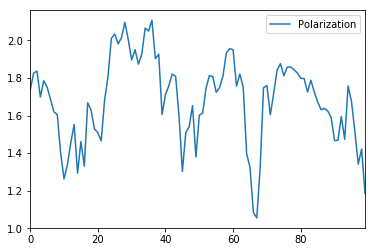

In [18]:
# Plot cohesion factor
%matplotlib inline

polarization = model.datacollector.get_model_vars_dataframe()
polarization.plot()

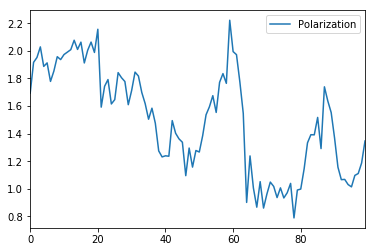

In [19]:
# Runs the model with vision - changed to 10 (units unknown)
# Runs the model for (n) steps.
model = ShoalModel(n=100, width=100, height=100, speed=5, vision=10, avoidance=2)
for i in range(100):
    model.step()
    
%matplotlib inline

polarization = model.datacollector.get_model_vars_dataframe()
polarization.plot()

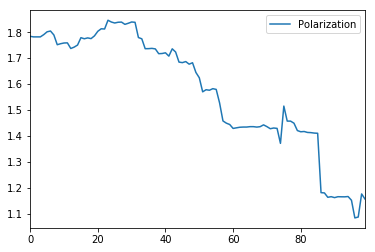

In [20]:
# Runs the model with vision - changed to 1 (units unknown)
# Runs the model for (n) steps.
model = ShoalModel(n=100, width=100, height=100, speed=5, vision=1, avoidance=2)
for i in range(100):
    model.step()
    
%matplotlib inline

polarization = model.datacollector.get_model_vars_dataframe()
polarization.plot()

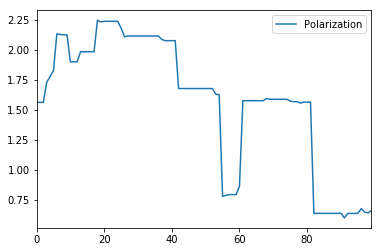

In [21]:
# Runs the model with number of agents - changed to 10
# Runs the model for (n) steps.
model = ShoalModel(n=10, width=100, height=100, speed=5, vision=5, avoidance=2)
for i in range(100):
    model.step()
    
%matplotlib inline

polarization = model.datacollector.get_model_vars_dataframe()
polarization.plot()

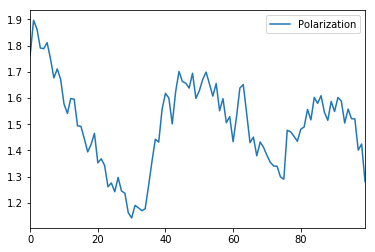

In [22]:
# Runs the model with number of agents - changed to 1000
# Runs the model for (n) steps.
model = ShoalModel(n=1000, width=100, height=100, speed=5, vision=5, avoidance=2)
for i in range(100):
    model.step()
    
%matplotlib inline

polarization = model.datacollector.get_model_vars_dataframe()
polarization.plot()